# Simulation of Audio-Visual Duration Estimation with Causal Inference Model
This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls.
### Experimenter knows the true durations:
Standard duration($S_s$) is always 0.5s, test duration varies($S_t$).
We simulate and give the parameters to the model, and see how the estimates change.
Parameters:
- $\sigma_a$: Standard deviation of auditory measurement noise
- $\sigma_v$: Standard deviation of visual measurement noise
- $p_c$: Prior probability of common cause
### Parameters we dont need to adjust specifically:
- $c$: Conflict level between auditory and visual stimuli
- $\tmin$ and $\tmax$: Minimum and maximum test durations

### Steps:
1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5]
2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0]
3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms
4. For each combination of S_s, delta, and c:
    - Calculate test duration: S_t = S_s + delta + c
5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements.
6. Use the causal inference model to compute the final estimates based on the measurements and parameters.


In [43]:
# import lbraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, gaussian_kde
from ipywidgets import interact, FloatSlider, widgets
from scipy.special import expit  # Sigmoid function for probability mapping
import warnings


In [44]:
## Simulation of Audio-Visual Duration Estimation with Causal Inference Model This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls. ### Experimenter knows the true durations: Standard duration($S_s$) is always 0.5s, test duration varies($S_t$). We simulate and give the parameters to the model, and see how the estimates change. Parameters: - $\sigma_a$: Standard deviation of auditory measurement noise - $\sigma_v$: Standard deviation of visual measurement noise - $p_c$: Prior probability of common cause ### Parameters we dont need to adjust specifically: - $c$: Conflict level between auditory and visual stimuli - $\tmin$ and $\tmax$: Minimum and maximum test durations ### Steps: 1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5] 2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0] 3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms 4. For each combination of S_s, delta, and c: - Calculate test duration: S_t = S_s + delta + c 5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements. 6. Use the causal inference model to compute the final estimates based on the measurements and parameters.
# Standard durations of auditory stimuli
S_a_s = 0.5  # seconds
# repeat
S_a_s = np.repeat(S_a_s, 9940)
# Range of test durations (difference from standard) -100% to +100%
delta_percent = np.linspace(-0.95, 0.95, 7)  # -100% to +100%
# Convert percentage differences to absolute time differences (in seconds)
delta = delta_percent * S_a_s[0]  # since S_a_s is constant
# Constant conflict levels (in seconds)
c = np.array([-0.25, -0.167, -0.083, 0.0, 0.083, 0.167, 0.25])  # seconds
# Repeat each conflict level to match the number of standard durations
c = np.tile(c, int(len(S_a_s) / len(c)))
# Reshape delta to match the dimensions of S_a_s for broadcasting
delta = np.tile(delta, int(len(S_a_s) / len(delta)))

# Calculate test durations
S_a_t = S_a_s + delta 
S_v_s = S_a_s + c  # Visual test durations with conflict
S_v_t = S_a_t # no conflict in test durations for visual
# Combine standard and test durations, delta, and conflict into a single dataset
simData=np.column_stack((S_a_s, S_a_t, S_v_s, S_v_t, delta, c))
# Columns: [S_a_s, S_a_t, S_v_s, S_v_t, delta, c]

# create a dataframe
import pandas as pd
simData = pd.DataFrame(simData, columns=['S_a_s', 'S_a_t', 'S_v_s', 'S_v_t', 'delta', 'c'])





In [45]:
simData

,S_a_s,S_a_t,S_v_s,S_v_t,delta,c
0,0.5,0.025000,0.250,0.025000,-0.475000,-0.250
1,0.5,0.183333,0.333,0.183333,-0.316667,-0.167
2,0.5,0.341667,0.417,0.341667,-0.158333,-0.083
3,0.5,0.500000,0.500,0.500000,0.000000,0.000
4,0.5,0.658333,0.583,0.658333,0.158333,0.083
...,...,...,...,...,...,...
9935,0.5,0.341667,0.417,0.341667,-0.158333,-0.083
9936,0.5,0.500000,0.500,0.500000,0.000000,0.000
9937,0.5,0.658333,0.583,0.658333,0.158333,0.083
9938,0.5,0.816667,0.667,0.816667,0.316667,0.167


In [46]:
# Check for potential issues with negative durations
print("Data summary:")
print(f"S_a_t min: {simData['S_a_t'].min():.3f}, max: {simData['S_a_t'].max():.3f}")
print(f"S_v_t min: {simData['S_v_t'].min():.3f}, max: {simData['S_v_t'].max():.3f}")
print(f"S_v_s min: {simData['S_v_s'].min():.3f}, max: {simData['S_v_s'].max():.3f}")

# Check if any values are negative or zero
negative_Sa_t = simData[simData['S_a_t'] <= 0]
negative_Sv_t = simData[simData['S_v_t'] <= 0] 
negative_Sv_s = simData[simData['S_v_s'] <= 0]

print(f"\nNegative/zero durations:")
print(f"S_a_t <= 0: {len(negative_Sa_t)} cases")
print(f"S_v_t <= 0: {len(negative_Sv_t)} cases") 
print(f"S_v_s <= 0: {len(negative_Sv_s)} cases")

if len(negative_Sv_s) > 0:
    print(f"Example negative S_v_s: {negative_Sv_s[['S_v_s', 'c']].head()}")

Data summary:
S_a_t min: 0.025, max: 0.975
S_v_t min: 0.025, max: 0.975
S_v_s min: 0.250, max: 0.750

Negative/zero durations:
S_a_t <= 0: 0 cases
S_v_t <= 0: 0 cases
S_v_s <= 0: 0 cases


Running causal inference simulation...
Simulating with 7 deltas and 7 conflict levels...
Model: log-space


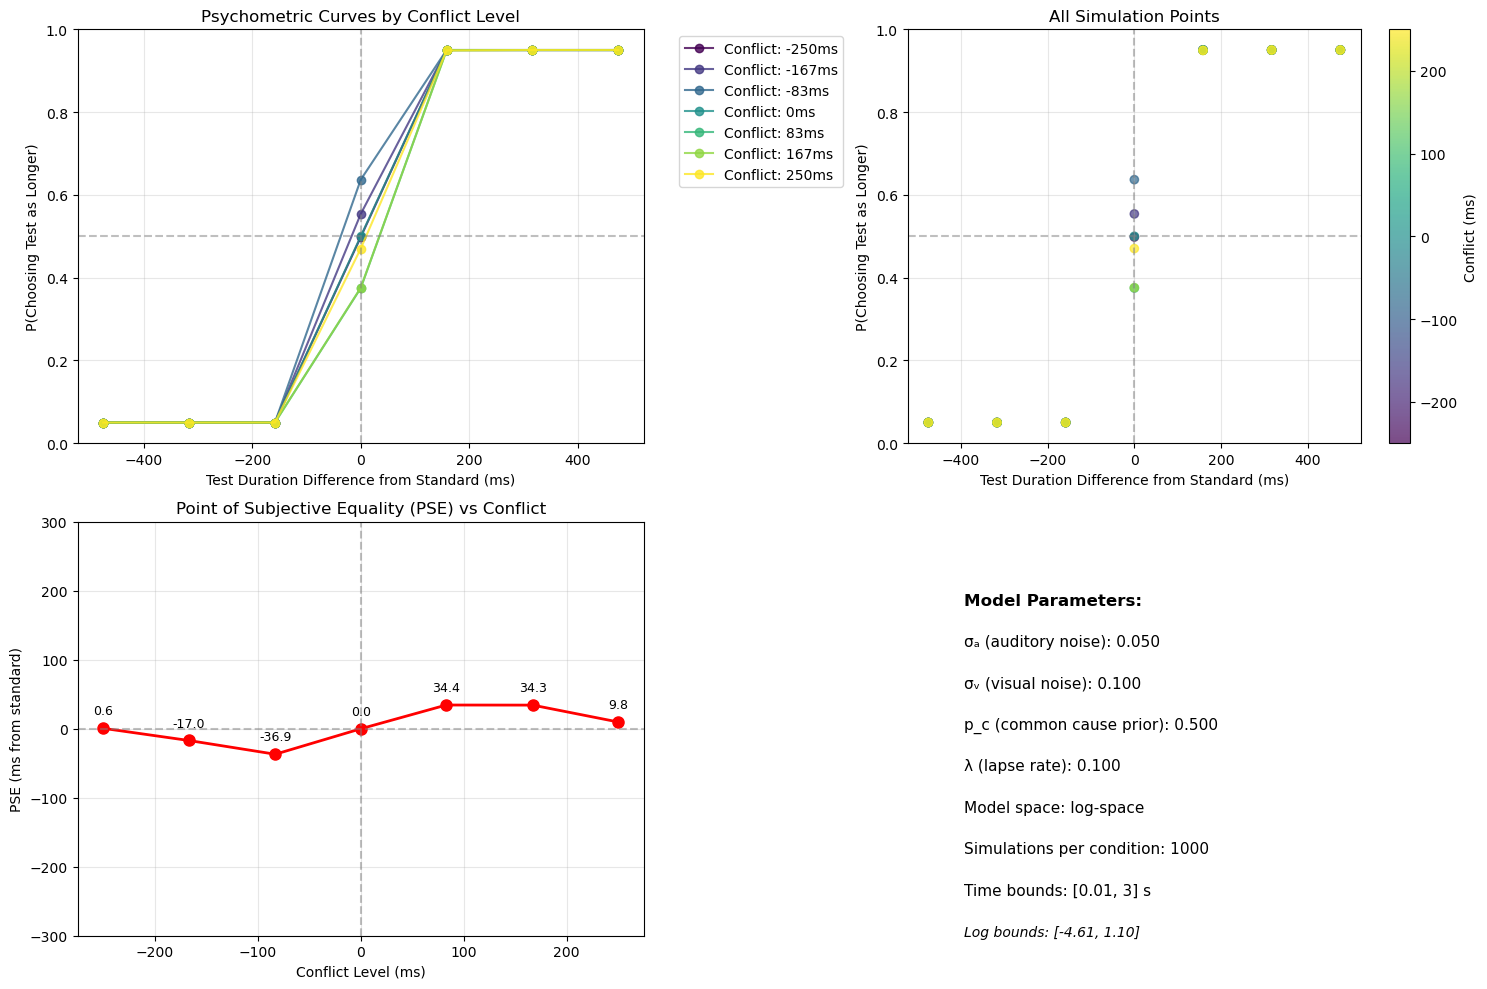

In [54]:
# --- FUSION MODEL IMPLEMENTATION ---
def fusion_estimate(m_a, m_v, sigma_a, sigma_v):
    """Bayesian optimal integration of auditory and visual measurements."""
    # Calculate weights based on reliabilities (inverse variances)
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    # Compute the fused estimate
    fused_estimate = (w_a * m_a + w_v * m_v) / (w_a + w_v)
    return fused_estimate

# --- CAUSAL INFERENCE MODEL IMPLEMENTATION ---
def p_single(m,sigma,t_min,t_max):
    """p(m | C=2) and Gaussian measurement noise N(m; y, sigma^2)."""
    hi_cdf= norm.cdf((t_max - m) /sigma)
    lo_cdf=norm.cdf((t_min-m)/sigma)
    return (hi_cdf-lo_cdf)/(t_max-t_min)

# Causal inference model for duration estimation
def L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max-mu_c)/sigma_c)
    lo_cdf = norm.cdf((t_min-mu_c)/sigma_c)
    
    expo = np.exp(-(m_a-m_v)**2/(2*(sigma_a**2+sigma_v**2)))
    
    prior = 1/(t_max-t_min)
    return prior * sigma_c/np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf-lo_cdf) * expo

def L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    """ Likelihood of separate sources: product of two marginal likelihoods 
        two integral over two hidden duration y_a y_v"""
    return p_single(m_a,sigma_a,t_min,t_max) * p_single(m_v,sigma_v,t_min,t_max)

def posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max):
    """ Posterior probability of common cause P(C=1 | m_a,m_v) """
    # Likelihoods under each causal structure
    L1 = L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    L2 = L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    # Unnormalized posteriors
    post_C1_unnorm = L1 * p_c
    post_C2_unnorm = L2 * (1 - p_c)
    # Normalization constant
    norm_const = post_C1_unnorm + post_C2_unnorm
    
    # Handle numerical stability
    if np.isscalar(norm_const):
        if norm_const == 0:
            return 0.5
    else:
        norm_const = np.where(norm_const == 0, 1e-10, norm_const)
    
    # Posterior probabilities
    post_C1 = post_C1_unnorm / norm_const
    return post_C1

def causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max):
    """Causal inference duration estimate (stays in current space - log or linear)"""
    # Posterior probability of common cause
    p_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    
    # Estimate under common cause (fused estimate)
    est_C1 = fusion_estimate(m_a, m_v, sigma_a, sigma_v)
    # Estimate under separate causes (auditory estimate)
    est_C2 = m_a
    
    # Final estimate as a weighted average
    final_estimate = p_C1 * est_C1 + (1 - p_C1) * est_C2
    return final_estimate

def estimate_duration(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max,lambda_=0.1, model="linear-space"):
    """ Final duration estimate as a weighted average of estimates under each causal structure """
    
    if model == "log-space":
        # For log-space model: measurements are in log space, causal inference in log space
        # t_min and t_max should also be in log space
        log_t_min = np.log(t_min)
        log_t_max = np.log(t_max)
        
        # Do causal inference in log space
        log_estimate = causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, log_t_min, log_t_max)
        
        # Convert back to linear space for decision
        final_estimate = np.exp(log_estimate)
        
    else:  # linear-space
        # For linear-space model: everything in linear space
        final_estimate = causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    
    return final_estimate

# Calculate probabilities of choosing test longer than standard for each condition
def prob_test_longer_condition(S_a_s, S_a_t, S_v_s, S_v_t, sigma_a, sigma_v, p_c, t_min, t_max, lambda_=0.1, model="linear-space", nSimul=1000):
    """ Calculate the probability of choosing the test duration as longer than the standard duration for a specific condition. """
    
    # Check for invalid durations (≤ 0) when using log-space
    if model == "log-space":
        min_duration = 1e-6  # Very small positive number
        S_a_s = max(S_a_s, min_duration)
        S_a_t = max(S_a_t, min_duration)
        S_v_s = max(S_v_s, min_duration)
        S_v_t = max(S_v_t, min_duration)
    
    # Generate measurements with noise
    if model == "log-space":
        # Measurements are Gaussian in log space (like your main implementation)
        m_a_s = np.random.normal(np.log(S_a_s), scale=sigma_a, size=nSimul)
        m_a_t = np.random.normal(np.log(S_a_t), scale=sigma_a, size=nSimul)
        m_v_s = np.random.normal(np.log(S_v_s), scale=sigma_v, size=nSimul)
        m_v_t = np.random.normal(np.log(S_v_t), scale=sigma_v, size=nSimul)
    else:
        m_a_s = np.random.normal(S_a_s, scale=sigma_a, size=nSimul)
        m_a_t = np.random.normal(S_a_t, scale=sigma_a, size=nSimul)
        m_v_s = np.random.normal(S_v_s, scale=sigma_v, size=nSimul)
        m_v_t = np.random.normal(S_v_t, scale=sigma_v, size=nSimul)
    
    # Estimate durations
    est_standard = estimate_duration(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, model)
    est_test = estimate_duration(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, model)
    
    # Calculate probability
    p_base = np.mean(est_test > est_standard)
    p_final = (1 - lambda_) * p_base + lambda_ * 0.5
    return p_final

# Updated simulation function that generates psychometric curves
def simulate_duration_estimation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model="linear-space", nSimul=1000):
    """
    Simulate duration estimation and generate psychometric curves for different conflict levels.
    """
    # Get unique conditions
    unique_deltas = np.sort(simData['delta'].unique())
    unique_conflicts = np.sort(simData['c'].unique())
    
    # Time bounds for uniform prior on durations
    t_min = 0.01  # seconds
    t_max = 3  # seconds
    
    # Initialize results storage
    results = []
    
    print(f"Simulating with {len(unique_deltas)} deltas and {len(unique_conflicts)} conflict levels...")
    print(f"Model: {model}")
    
    # For each conflict level
    for conflict in unique_conflicts:
        conflict_results = []
        
        # For each delta (test duration difference)
        for delta in unique_deltas:
            # Get the stimulus durations for this condition
            S_a_s = 0.5  # Standard auditory duration
            S_a_t = S_a_s + delta  # Test auditory duration
            S_v_s = S_a_s + conflict  # Standard visual duration (with conflict)
            S_v_t = S_a_t  # Test visual duration (same as auditory test)
            
            # Skip conditions with non-positive durations for log-space
            if model == "log-space" and (S_a_t <= 0 or S_v_t <= 0):
                print(f"Skipping condition: delta={delta:.3f}, conflict={conflict:.3f} (negative duration)")
                continue
            
            # Calculate probability for this condition
            p_longer = prob_test_longer_condition(
                S_a_s, S_a_t, S_v_s, S_v_t, 
                sigma_a, sigma_v, p_c, t_min, t_max, lambda_, model, nSimul
            )
            
            conflict_results.append({
                'delta': delta,
                'delta_ms': delta * 1000,
                'conflict': conflict,
                'conflict_ms': conflict * 1000,
                'p_test_longer': p_longer,
                'S_a_s': S_a_s,
                'S_a_t': S_a_t,
                'S_v_s': S_v_s,
                'S_v_t': S_v_t
            })
        
        results.extend(conflict_results)
    
    # Convert to DataFrame for easier plotting
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("No valid conditions found!")
        return results_df
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Psychometric curves for each conflict level
    plt.subplot(2, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_conflicts)))
    
    for i, conflict in enumerate(unique_conflicts):
        conflict_data = results_df[results_df['conflict'] == conflict]
        if len(conflict_data) > 0:
            plt.plot(conflict_data['delta_ms'], conflict_data['p_test_longer'], 
                    'o-', color=colors[i], label=f'Conflict: {conflict*1000:.0f}ms', alpha=0.8)
    
    plt.title('Psychometric Curves by Conflict Level')
    plt.xlabel('Test Duration Difference from Standard (ms)')
    plt.ylabel('P(Choosing Test as Longer)')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: All data points as scatter
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(results_df['delta_ms'], results_df['p_test_longer'], 
                         c=results_df['conflict_ms'], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Conflict (ms)')
    plt.title('All Simulation Points')
    plt.xlabel('Test Duration Difference from Standard (ms)')
    plt.ylabel('P(Choosing Test as Longer)')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 3: PSE for each conflict level (FIXED)
    plt.subplot(2, 2, 3)
    pse_by_conflict = []
    
    for conflict in unique_conflicts:
        conflict_data = results_df[results_df['conflict'] == conflict].sort_values('delta_ms')
        # Find PSE (point where p = 0.5) by interpolation
        if len(conflict_data) > 1:
            try:
                # Ensure we have data points around 0.5
                p_values = conflict_data['p_test_longer'].values
                delta_values = conflict_data['delta_ms'].values
                
                if p_values.min() <= 0.5 <= p_values.max():
                    pse = np.interp(0.5, p_values, delta_values)
                else:
                    # If no crossing, estimate based on closest points
                    closest_idx = np.argmin(np.abs(p_values - 0.5))
                    pse = delta_values[closest_idx]
                
                pse_by_conflict.append({
                    'conflict_ms': conflict*1000, 
                    'pse_ms': pse,
                    'conflict': conflict
                })
            except:
                pse_by_conflict.append({
                    'conflict_ms': conflict*1000, 
                    'pse_ms': 0,
                    'conflict': conflict
                })
    
    if pse_by_conflict:
        pse_df = pd.DataFrame(pse_by_conflict)
        plt.plot(pse_df['conflict_ms'], pse_df['pse_ms'], 'ro-', linewidth=2, markersize=8)
        plt.title('Point of Subjective Equality (PSE) vs Conflict')
        plt.xlabel('Conflict Level (ms)')
        plt.ylabel('PSE (ms from standard)')
        plt.ylim(-300, 300)
        plt.grid(True, alpha=0.3)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
        
        # Add text showing PSE values
        for _, row in pse_df.iterrows():
            plt.annotate(f'{row["pse_ms"]:.1f}', 
                        (row['conflict_ms'], row['pse_ms']), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    # Plot 4: Model parameters summary
    plt.subplot(2, 2, 4)
    plt.text(0.1, 0.8, f'Model Parameters:', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'σₐ (auditory noise): {sigma_a:.3f}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f'σᵥ (visual noise): {sigma_v:.3f}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, f'p_c (common cause prior): {p_c:.3f}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.4, f'λ (lapse rate): {lambda_:.3f}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f'Model space: {model}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, f'Simulations per condition: {nSimul}', fontsize=11, transform=plt.gca().transAxes)
    plt.text(0.1, 0.1, f'Time bounds: [{t_min}, {t_max}] s', fontsize=11, transform=plt.gca().transAxes)
    
    # Add comparison info
    if model == "log-space":
        plt.text(0.1, 0.0, f'Log bounds: [{np.log(t_min):.2f}, {np.log(t_max):.2f}]', fontsize=10, transform=plt.gca().transAxes, style='italic')
    
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run the simulation with log-space model (your main model)
print("Running causal inference simulation...")
results = simulate_duration_estimation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model="log-space", nSimul=1000)

In [56]:
# Interactive widget for parameter exploration
def interactive_simulation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model_space="linear-space", n_simulations=500):
    """Interactive version of the simulation with parameter controls"""
    results = simulate_duration_estimation(
        sigma_a=sigma_a, 
        sigma_v=sigma_v, 
        p_c=p_c, 
        lambda_=lambda_, 
        model=model_space, 
        nSimul=n_simulations
    )
    return results

# Create interactive widget
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider

interact(
    interactive_simulation,
    sigma_a=FloatSlider(value=0.05, min=0.01, max=1, step=0.01, description='σₐ (auditory):'),
    sigma_v=FloatSlider(value=0.1, min=0.01, max=0.3, step=0.01, description='σᵥ (visual):'),
    p_c=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='p_c (common cause):'),
    lambda_=FloatSlider(value=0.1, min=0.0, max=0.5, step=0.01, description='λ (lapse rate):'),
    model_space=Dropdown(options=['linear-space', 'log-space'], value='linear-space', description='Model space:'),
    n_simulations=IntSlider(value=500, min=100, max=2000, step=100, description='N simulations:')
);

interactive(children=(FloatSlider(value=0.05, description='σₐ (auditory):', max=1.0, min=0.01, step=0.01), Flo…